<a href="https://colab.research.google.com/github/vbwanere/SEDS_in_jax/blob/main/gmr_lib/GMR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GMR from scratch**

Python jax implementation of Gaussian Mixture Regression Model

# 1\. Introduction:

We estimate a joint density of the inputs $x\  \epsilon \ \mathbb R^N$ and outputs $\dot x \ \epsilon \ \mathbb R^P$ through a K-component Gaussian mixture model as follows:

\begin{equation}
\tag{1}
p(x, \dot x|\Theta) = \sum_{k=1}^{K} \pi_k p(x, \dot x|\mu^k \Sigma^k)
\end{equation}

where,\
$\sum_{k=1}^{K} \pi_k = 1$ and $\mu^k = \begin{bmatrix}
\mu_{x}^{k}\\
\mu_{\dot x}^{k}
\end{bmatrix}$,
and $\ \Sigma^k =
\begin{bmatrix}
\Sigma_{xx}^{k} & \Sigma_{x\dot x}^{k} \\
\Sigma_{\dot xx}^{k} & \Sigma_{\dot x \dot x}^{k}
\end{bmatrix}$.

The conditional density is given by:
\begin{equation}
\tag{2}
p(\dot x|x) = \sum_{k=1}^{K} \gamma_k p(y|x;\mu^k \Sigma^k)
\end{equation}

where,
\begin{equation}
\tag{3}
\gamma_k = \frac{\pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}{\sum_{k=1}^{K} \pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}
\end{equation}

The regressive function $\dot x = f(x)$ is given by the expectation over this conditional density:
\begin{equation}
\tag{4}
\dot x = f(x) = \mathbf E[p(\dot x|x)] = \sum_{k=1}^{K} \gamma_k(x)\tilde \mu^k(x)
\end{equation}

where,
\begin{equation}
\tag{4}
\tilde \mu = \mu_{\dot x}^k + \Sigma_{\dot x x}^k(\Sigma_{x x}^k)^{-1}(x - \mu_x^k)
\end{equation}


## 1.1 Undestanding the dataset:

1. Inputs $x \ \epsilon \ \mathbb R^N$, for $M$ number of trajectories with each of length $T_m$ we have for $m^{th}$ trajectory:
\begin{equation}
X_m =
\begin{bmatrix}
x_1^1 & x_1^2 & ....... & x_1^{T_m}\\
& & &\\
x_N^1 & x_N^2 & ....... & x_N^{T_m}\\
\end{bmatrix}
\end{equation}

where, $m \ \epsilon \  \{1,....,M\}$, and $\{\mathbf X, \dot{\mathbf X}\} = \{X^m, \dot X^m\}_{m=1}^{M} = \{\{{x^{t,m}, {\dot x^{t,m}}\}_{t=1}^{T_m}}\}_{m=1}^{M}$.

# 2\. `GMR` class:

In [13]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jacfwd, jit, random, vmap
from jax.scipy.stats import multivariate_normal
from sklearn import mixture
import scipy
import scipy.io
import pprint as pp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools

Importing LASA Handwritten Dataset:\
Please refer to [this python library](https://github.com/justagist/pyLasaDataset) for the [Handwritten Human Motion LASA Datset](https://www.epfl.ch/labs/lasa/datasets/).\
Please understand the dataset [here](https://bitbucket.org/khansari/lasahandwritingdataset/src/master/Readme.txt).

In [3]:
from pyLasaDataset import DataSet as lasa
from pyLasaDataset import utilities
plot_lasa = utilities.plot_model

Using LASA DataSet from /home/vbwanere/.local/lib/python3.10/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


Import the `GaussianMixture` class from **gaussian_mixture** file:

In [4]:
import sys
sys.path.append('/home/vbwanere/OneDrive/GitHub_repos/GitHub_repos_python/seds_in_jax/gmm_lib')
from gaussian_mixture import GaussianMixture

Visualizing Trajectories:

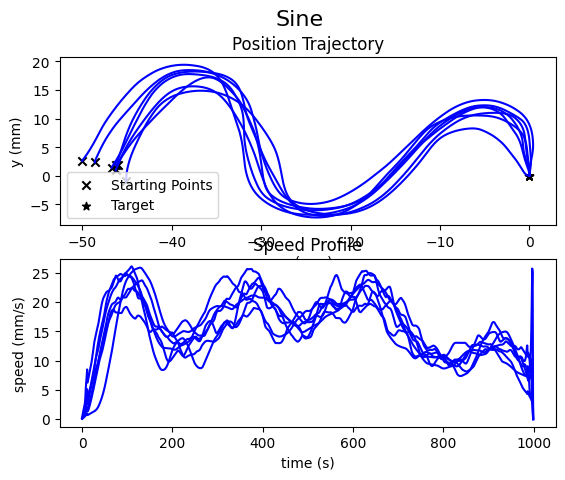

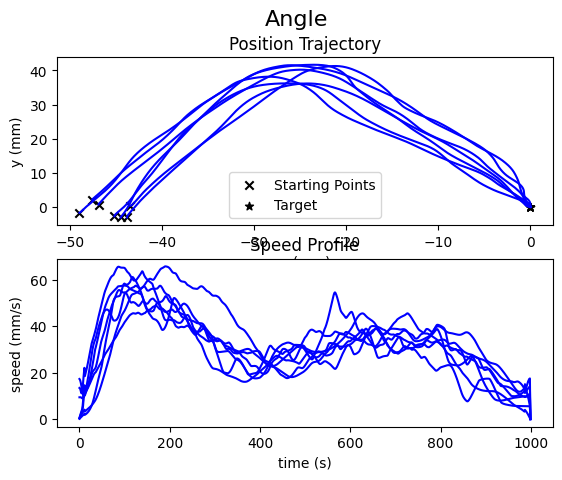

In [5]:
sine = lasa.Sine
angle = lasa.Angle
plot_lasa(sine)
plot_lasa(angle)

Using GMR for position dataset:

In [6]:
angle_demos = angle.demos
angle_1 = angle_demos[0]
angle_1_pos = angle_1.pos.T # shape (1000, 2)

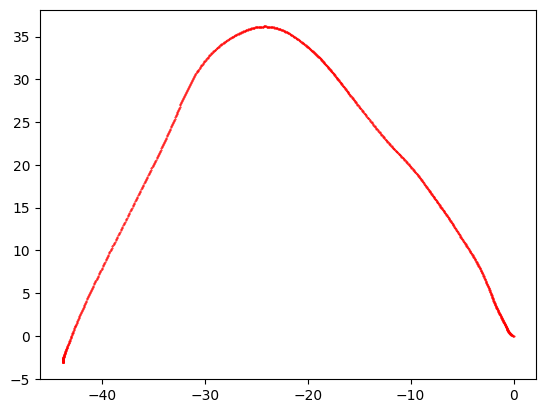

In [6]:
plt.scatter(angle_1_pos[:, 0], angle_1_pos[:, 1], c='r', marker = '.', s=0.8)

In [188]:
gmm_angle =  GaussianMixture(k=2, max_iter=50)
gmm_angle.fit(angle_1_pos)
pred_angle_1_pos = gmm_angle.predict(angle_1_pos)

/home/vbwanere/OneDrive/GitHub_repos/GitHub_repos_python/seds_in_jax/gmm_lib/gaussian_mixture.py:93: RuntimeWarning: invalid value encountered in divide
  responsibility_matrix = numerator / denominator


In [189]:
def plot_gmm(mean, cov, color='k'):
    """Plot a single gaussian component"""
    # Get the eigenvalues and eigenvectors
    eigen_vals, eigen_vecs = np.linalg.eig(cov)

    # Get the index of the largest eigenvalue 
    idx = eigen_vals.argsort()[::-1] 
    eigen_vals, eigen_vecs = eigen_vals[idx], eigen_vecs[:,idx]

    theta = np.degrees(np.arctan2(*eigen_vecs[:,0][::-1]))

    # Ellipse properties 
    width, height = 2 * np.sqrt(eigen_vals)
    ellipse = patches.Ellipse(mean, width, height, angle=theta, facecolor='none', edgecolor=color)
    # ellipse.set_linestyle('--')
    ellipse.set_linewidth(2)
    return ellipse

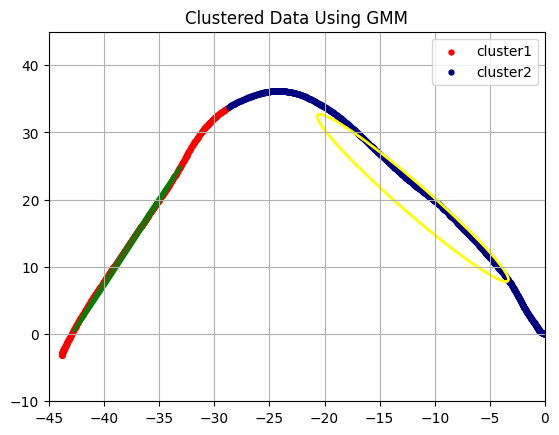

In [190]:
color_iter_data = itertools.cycle(["red", "navy", "c", "cornflowerblue", "gold",\
    "darkorange", "green", "blue", "purple", "pink"])
color_iter_gmm = itertools.cycle(["green", "yellow", "black", "cornflowerblue", "gold"])

# plt.figure(figsize=(10, 10))
fig, ax = plt.subplots()
for i in range(gmm_angle.k):
    ax.scatter(angle_1_pos[pred_angle_1_pos == i, 0],\
        angle_1_pos[pred_angle_1_pos == i, 1], s=50,\
        c=next(color_iter_data), marker='.', label='cluster' + str(i + 1))
    

for i in range(gmm_angle.k):
    ellipse = plot_gmm(gmm_angle.means[i], gmm_angle.covariances[i], color=next(color_iter_gmm))
    ax.add_patch(ellipse)
    
ax.set_xlim(-45, 0)
ax.set_ylim(-10, 45)
plt.title('Clustered Data Using GMM')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [191]:
gmm_angle = mixture.GaussianMixture(
    n_components=2,
    n_init=10, max_iter=30,
    tol=1e-04, random_state=0
)
gmm_angle.fit(angle_1_pos)
pred_angle_1_pos2 = gmm_angle.predict(angle_1_pos)

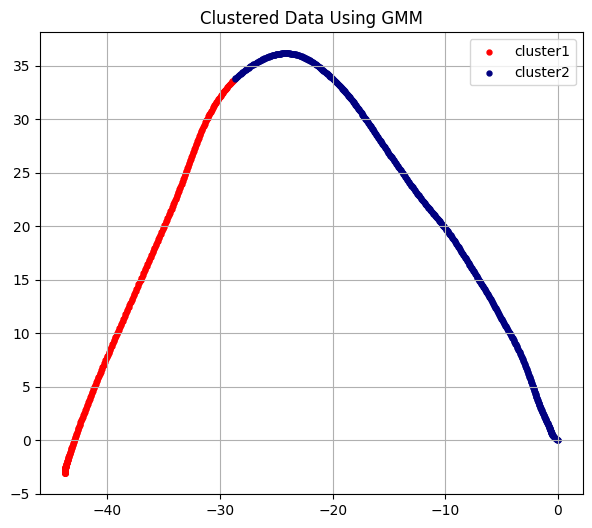

In [192]:
color_iter = itertools.cycle(["red", "navy", "c", "cornflowerblue", "gold",\
    "darkorange", "green", "blue", "purple", "pink"])
plt.figure(figsize=(7, 6))

for i in range(2):
    plt.scatter(
    angle_1_pos[pred_angle_1_pos == i, 0], angle_1_pos[pred_angle_1_pos == i, 1],
    s=50, c=next(color_iter),
    marker='.', label='cluster' + str(i + 1)
)
plt.title('Clustered Data Using GMM')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

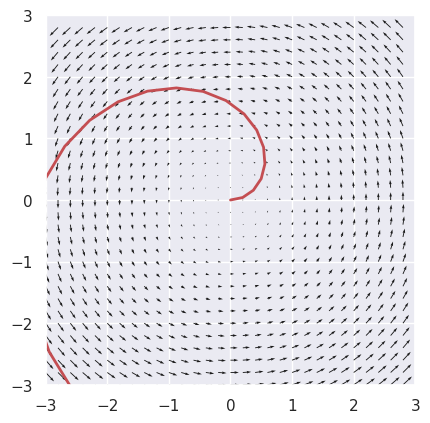

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Generate grid of x,y points
x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2)) 

# Compute u,v vectors at each point
u = -y
v = x

# Plot trajectory
t = np.linspace(0, 20, 100)
x_t = t * np.cos(t)
y_t = t * np.sin(t)

# Plot vectors and trajectory
fig, ax = plt.subplots()
ax.quiver(x, y, u, v)
ax.plot(x_t, y_t, 'r-', linewidth=2)

ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))
plt.show()

## 1.2 Subsection 2:

In [ ]:
"""
sample code here
"""

### 1.2.1 item 1:

In [ ]:
"""
sample code here
"""

### 1.2.2 item 2:

In [ ]:
"""
sample code here
"""

# 2\. Section 2:

## 2.1\. Subsection 1:
### Subsection description in one line:

In [4]:
from pprint import pprint as print

In [5]:
print("The function predicts the class labels for a given set of input data.\
      :param X: The parameter X represents the input data for which you want to make predictions.\
      It is a matrix or array-like object with shape (n_samples, n_features),\
      where n_samples is the number of samples or instances in the dataset, and n_features is the number of features or\
      attributes for each sample:return: the index of the maximum probability value in the responsibility_k matrix for each data point.")

('The function predicts the class labels for a given set of input data.      '
 ':param X: The parameter X represents the input data for which you want to '
 'make predictions.      It is a matrix or array-like object with shape '
 '(n_samples, n_features),      where n_samples is the number of samples or '
 'instances in the dataset, and n_features is the number of features or      '
 'attributes for each sample:return: the index of the maximum probability '
 'value in the responsibility_k matrix for each data point.')
